# Deep Convolutional GAN (DCGAN) with MNIST

This is a follow-up on [gan_mnist.ipynb](gan_mnist.ipynb).  It uses deep convolutional networks in the generator and the discriminator.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

We only use the images not the categorical labels.

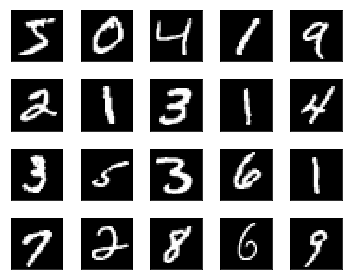

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Generator

The original DCGAN paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

In this notebook, I used smaller networks than what the original paper [[3]](#ref3) uses as our image size is 28x28 and it has only 1 channel.

The generator takes a latent sample of 100 random numbers and generates a 28x28 image with 1 channel.

The first layer accepts 784 data points just like [gan_mnist.ipynb](gan_mnist.ipynb).  Then, it reshapes the data into 7x7 with 16 filters.  Afterwards, two transposed convolution layers will up-sample the data shape into 28x28.

For the details of the tranposed convolution, see [transposed_convolution.ipynb](transposed_convolution.ipynb).

In [6]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 28x28 image with 1 channel.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [gan_mnist.ipynb](gan_mnist.ipynb), I used a fully connected layer with 784 (=28x28) neurons.  To make this discriminator comparable, I use the same number of neurons in the last fully connected hidden layer, and then added convolution layers beforehands.

Note: using the decreasing number of filters may be a bit unusual but I did this to make the discriminator network and the generator network to have same kind of increase in the number of convolutional network neurons (hopefully keeping their power in balance).

In [7]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

### About Batch Normalization

As for the batch normalization, it was applied to most of the layers but not all.  The below is a quote from the original DCGAN paper [[3]](#ref3).

> Directly applying batchnorm to all layers, however, resulted in sample oscillation and model instability. This was avoided by not applying batchnorm to the generator output layer and the discriminator input layer.


## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [8]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [9]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The below is to show the losses.

In [12]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()    

The below is to show the generated images.

In [13]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [14]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

Epoch:  1/100 Discriminator Loss: 2.7356 Generator Loss: 0.7144
Epoch:  2/100 Discriminator Loss: 1.1015 Generator Loss: 6.5365
Epoch:  3/100 Discriminator Loss: 0.1907 Generator Loss: 2.0632
Epoch:  4/100 Discriminator Loss: 7.6143 Generator Loss:10.7723
Epoch:  5/100 Discriminator Loss: 4.8363 Generator Loss: 3.3136
Epoch:  6/100 Discriminator Loss: 3.7388 Generator Loss: 2.7866
Epoch:  7/100 Discriminator Loss: 2.9816 Generator Loss: 2.3544
Epoch:  8/100 Discriminator Loss: 3.8926 Generator Loss: 5.3916
Epoch:  9/100 Discriminator Loss: 6.8884 Generator Loss: 6.3789
Epoch: 10/100 Discriminator Loss:14.2377 Generator Loss:14.5691


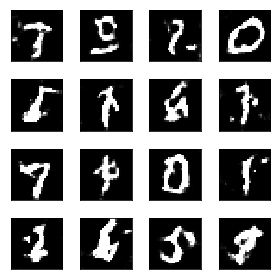

Epoch: 11/100 Discriminator Loss:13.5121 Generator Loss:13.2578
Epoch: 12/100 Discriminator Loss: 1.4278 Generator Loss: 1.1321
Epoch: 13/100 Discriminator Loss: 7.0365 Generator Loss: 5.5239
Epoch: 14/100 Discriminator Loss: 4.3074 Generator Loss: 4.1456
Epoch: 15/100 Discriminator Loss: 2.3359 Generator Loss: 3.0067
Epoch: 16/100 Discriminator Loss: 1.9120 Generator Loss: 2.2706
Epoch: 17/100 Discriminator Loss: 4.0722 Generator Loss: 4.0827
Epoch: 18/100 Discriminator Loss: 3.8986 Generator Loss: 5.1455
Epoch: 19/100 Discriminator Loss: 3.2432 Generator Loss: 3.5515
Epoch: 20/100 Discriminator Loss: 1.7348 Generator Loss: 1.7433


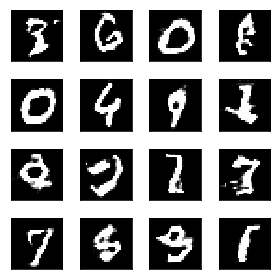

Epoch: 21/100 Discriminator Loss: 2.8088 Generator Loss: 3.3484
Epoch: 22/100 Discriminator Loss: 1.9262 Generator Loss: 1.9825
Epoch: 23/100 Discriminator Loss: 4.0126 Generator Loss: 4.6245
Epoch: 24/100 Discriminator Loss: 1.5230 Generator Loss: 0.5246
Epoch: 25/100 Discriminator Loss: 2.5404 Generator Loss: 1.1629
Epoch: 26/100 Discriminator Loss: 1.6966 Generator Loss: 0.4383
Epoch: 27/100 Discriminator Loss: 1.5087 Generator Loss: 0.8402
Epoch: 28/100 Discriminator Loss: 2.2959 Generator Loss: 3.0494
Epoch: 29/100 Discriminator Loss: 2.5218 Generator Loss: 0.2009
Epoch: 30/100 Discriminator Loss: 1.6397 Generator Loss: 2.1446


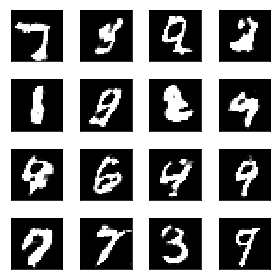

Epoch: 31/100 Discriminator Loss: 1.6189 Generator Loss: 2.1534
Epoch: 32/100 Discriminator Loss: 1.9528 Generator Loss: 3.2465
Epoch: 33/100 Discriminator Loss: 1.9479 Generator Loss: 2.7221
Epoch: 34/100 Discriminator Loss: 3.0369 Generator Loss: 3.0408
Epoch: 35/100 Discriminator Loss: 4.4765 Generator Loss: 6.3650
Epoch: 36/100 Discriminator Loss: 1.5172 Generator Loss: 2.9716
Epoch: 37/100 Discriminator Loss: 1.9757 Generator Loss: 2.5600
Epoch: 38/100 Discriminator Loss: 3.7256 Generator Loss: 4.1371
Epoch: 39/100 Discriminator Loss:15.2826 Generator Loss:14.0233
Epoch: 40/100 Discriminator Loss: 6.3285 Generator Loss: 5.3273


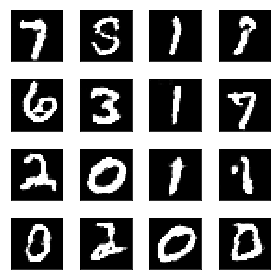

Epoch: 41/100 Discriminator Loss: 3.8977 Generator Loss: 3.9135
Epoch: 42/100 Discriminator Loss: 3.8568 Generator Loss: 5.8047
Epoch: 43/100 Discriminator Loss: 1.7994 Generator Loss: 1.7277
Epoch: 44/100 Discriminator Loss: 5.3219 Generator Loss: 6.0221
Epoch: 45/100 Discriminator Loss: 1.7663 Generator Loss: 1.9248
Epoch: 46/100 Discriminator Loss:10.0883 Generator Loss:10.7173
Epoch: 47/100 Discriminator Loss: 4.4883 Generator Loss: 4.7383
Epoch: 48/100 Discriminator Loss:13.5439 Generator Loss:14.4807
Epoch: 49/100 Discriminator Loss: 2.5699 Generator Loss: 3.1435
Epoch: 50/100 Discriminator Loss: 3.0090 Generator Loss: 3.2587


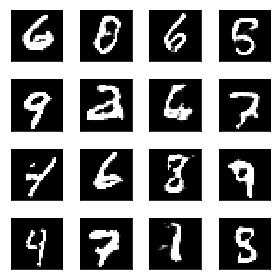

Epoch: 51/100 Discriminator Loss: 4.7188 Generator Loss: 4.7562
Epoch: 52/100 Discriminator Loss: 3.5139 Generator Loss: 5.0101
Epoch: 53/100 Discriminator Loss: 1.6159 Generator Loss: 2.1900
Epoch: 54/100 Discriminator Loss: 2.1211 Generator Loss: 2.4584
Epoch: 55/100 Discriminator Loss: 1.4081 Generator Loss: 1.7705
Epoch: 56/100 Discriminator Loss: 2.0400 Generator Loss: 2.4672
Epoch: 57/100 Discriminator Loss: 1.4965 Generator Loss: 1.2609
Epoch: 58/100 Discriminator Loss: 1.3316 Generator Loss: 1.3982
Epoch: 59/100 Discriminator Loss: 1.3567 Generator Loss: 2.2511
Epoch: 60/100 Discriminator Loss: 2.1518 Generator Loss: 2.6130


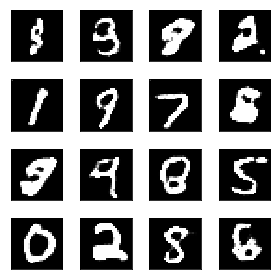

Epoch: 61/100 Discriminator Loss: 2.1311 Generator Loss: 2.9992
Epoch: 62/100 Discriminator Loss: 1.8602 Generator Loss: 2.6029
Epoch: 63/100 Discriminator Loss: 2.4389 Generator Loss: 2.0189
Epoch: 64/100 Discriminator Loss: 2.3069 Generator Loss: 3.4756
Epoch: 65/100 Discriminator Loss: 5.1731 Generator Loss: 4.7246
Epoch: 66/100 Discriminator Loss: 4.0980 Generator Loss: 3.9619
Epoch: 67/100 Discriminator Loss: 2.1781 Generator Loss: 3.6038
Epoch: 68/100 Discriminator Loss: 1.2535 Generator Loss: 2.4197
Epoch: 69/100 Discriminator Loss: 2.2509 Generator Loss: 2.8625
Epoch: 70/100 Discriminator Loss: 2.4683 Generator Loss: 3.6633


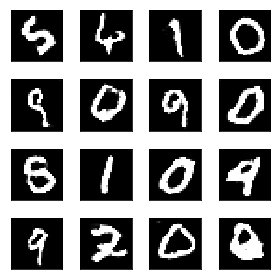

Epoch: 71/100 Discriminator Loss: 3.3261 Generator Loss: 3.5322
Epoch: 72/100 Discriminator Loss: 3.2260 Generator Loss: 3.5007
Epoch: 73/100 Discriminator Loss: 5.4929 Generator Loss: 4.0540
Epoch: 74/100 Discriminator Loss: 3.8150 Generator Loss: 4.7446
Epoch: 75/100 Discriminator Loss: 1.5867 Generator Loss: 2.6905
Epoch: 76/100 Discriminator Loss: 3.8024 Generator Loss: 4.4045
Epoch: 77/100 Discriminator Loss: 4.7304 Generator Loss: 2.4112
Epoch: 78/100 Discriminator Loss: 3.1597 Generator Loss: 4.2955
Epoch: 79/100 Discriminator Loss: 2.2647 Generator Loss: 2.2355
Epoch: 80/100 Discriminator Loss: 4.3661 Generator Loss: 4.4524


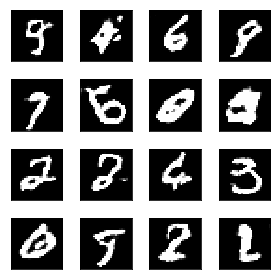

Epoch: 81/100 Discriminator Loss: 3.2917 Generator Loss: 3.6547
Epoch: 82/100 Discriminator Loss: 1.2209 Generator Loss: 2.2725
Epoch: 83/100 Discriminator Loss: 3.5781 Generator Loss: 4.5301
Epoch: 84/100 Discriminator Loss: 1.3449 Generator Loss: 2.0427
Epoch: 85/100 Discriminator Loss: 3.7023 Generator Loss: 5.8843
Epoch: 86/100 Discriminator Loss: 3.3996 Generator Loss: 2.9711
Epoch: 87/100 Discriminator Loss: 3.5081 Generator Loss: 3.7389
Epoch: 88/100 Discriminator Loss: 3.5340 Generator Loss: 3.8487
Epoch: 89/100 Discriminator Loss: 1.5601 Generator Loss: 2.2545
Epoch: 90/100 Discriminator Loss: 2.8719 Generator Loss: 3.2544


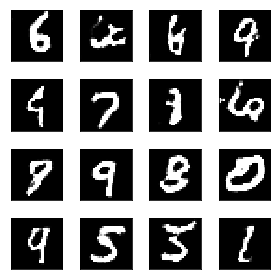

Epoch: 91/100 Discriminator Loss: 1.9073 Generator Loss: 2.2929
Epoch: 92/100 Discriminator Loss: 1.0578 Generator Loss: 1.7261
Epoch: 93/100 Discriminator Loss: 2.0630 Generator Loss: 3.6120
Epoch: 94/100 Discriminator Loss: 6.1956 Generator Loss: 7.6470
Epoch: 95/100 Discriminator Loss: 4.4643 Generator Loss: 4.8191
Epoch: 96/100 Discriminator Loss: 1.6738 Generator Loss: 2.5245
Epoch: 97/100 Discriminator Loss: 2.0638 Generator Loss: 2.2775
Epoch: 98/100 Discriminator Loss: 2.7651 Generator Loss: 4.2926
Epoch: 99/100 Discriminator Loss: 2.0267 Generator Loss: 2.7280
Epoch:100/100 Discriminator Loss: 1.4180 Generator Loss: 2.0450


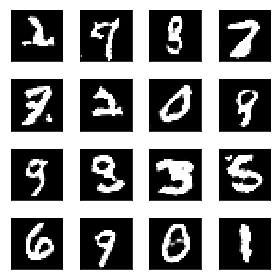

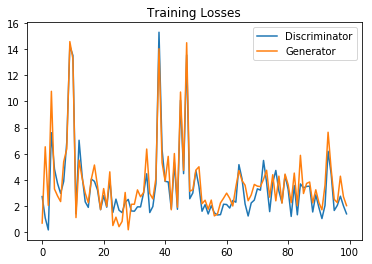

In [15]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01);

It's definitely much better than the results from the simple GAN MNIST model in [gan_mnist.ipynb](gan_mnist.ipynb).

Epoch:  1/100 Discriminator Loss: 0.4107 Generator Loss: 2.0994
Epoch:  2/100 Discriminator Loss: 1.8836 Generator Loss: 1.6207
Epoch:  3/100 Discriminator Loss:15.5494 Generator Loss:15.6823
Epoch:  4/100 Discriminator Loss:15.5277 Generator Loss:15.9398
Epoch:  5/100 Discriminator Loss: 4.6946 Generator Loss: 5.7051
Epoch:  6/100 Discriminator Loss: 0.9734 Generator Loss: 2.1980
Epoch:  7/100 Discriminator Loss: 4.4906 Generator Loss: 4.7214
Epoch:  8/100 Discriminator Loss:13.9835 Generator Loss:11.9733
Epoch:  9/100 Discriminator Loss: 4.3643 Generator Loss: 4.6467
Epoch: 10/100 Discriminator Loss: 2.1583 Generator Loss: 2.6461


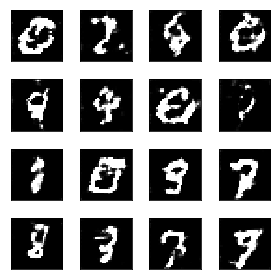

Epoch: 11/100 Discriminator Loss: 2.9774 Generator Loss: 4.9156
Epoch: 12/100 Discriminator Loss:12.8976 Generator Loss:14.1824
Epoch: 13/100 Discriminator Loss:12.2137 Generator Loss:12.2336
Epoch: 14/100 Discriminator Loss: 6.7834 Generator Loss: 7.2441
Epoch: 15/100 Discriminator Loss: 7.1325 Generator Loss: 8.0648
Epoch: 16/100 Discriminator Loss: 7.1024 Generator Loss: 8.9063
Epoch: 17/100 Discriminator Loss: 7.0913 Generator Loss: 9.0291
Epoch: 18/100 Discriminator Loss: 3.3632 Generator Loss: 4.2804
Epoch: 19/100 Discriminator Loss: 3.2963 Generator Loss: 5.4736
Epoch: 20/100 Discriminator Loss: 1.7592 Generator Loss: 0.6902


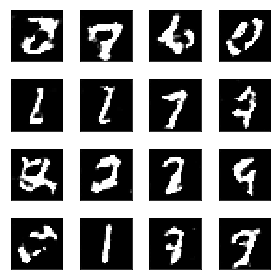

Epoch: 21/100 Discriminator Loss: 1.2387 Generator Loss: 0.9052
Epoch: 22/100 Discriminator Loss: 1.8807 Generator Loss: 1.7859
Epoch: 23/100 Discriminator Loss: 2.4974 Generator Loss: 4.5855
Epoch: 24/100 Discriminator Loss: 4.4281 Generator Loss: 5.9452
Epoch: 25/100 Discriminator Loss: 2.5066 Generator Loss: 1.6621
Epoch: 26/100 Discriminator Loss: 2.4061 Generator Loss: 1.3523
Epoch: 27/100 Discriminator Loss: 1.9206 Generator Loss: 3.2152
Epoch: 28/100 Discriminator Loss: 2.1586 Generator Loss: 4.6224
Epoch: 29/100 Discriminator Loss: 8.3026 Generator Loss: 7.0562
Epoch: 30/100 Discriminator Loss: 6.2774 Generator Loss: 7.8080


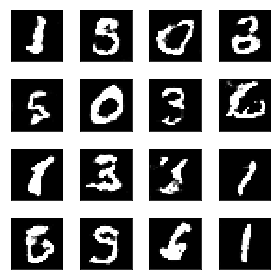

Epoch: 31/100 Discriminator Loss: 3.4837 Generator Loss: 3.8146
Epoch: 32/100 Discriminator Loss: 2.0757 Generator Loss: 2.0473
Epoch: 33/100 Discriminator Loss: 1.9698 Generator Loss: 1.0765
Epoch: 34/100 Discriminator Loss: 2.5563 Generator Loss: 3.8921
Epoch: 35/100 Discriminator Loss: 1.9325 Generator Loss: 1.1154
Epoch: 36/100 Discriminator Loss: 7.5879 Generator Loss: 9.4767
Epoch: 37/100 Discriminator Loss: 7.8222 Generator Loss: 8.0010
Epoch: 38/100 Discriminator Loss: 3.0312 Generator Loss: 4.4284
Epoch: 39/100 Discriminator Loss:10.7866 Generator Loss:10.9612
Epoch: 40/100 Discriminator Loss: 2.4396 Generator Loss: 2.0906


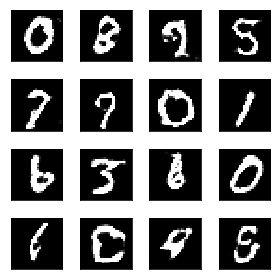

Epoch: 41/100 Discriminator Loss: 6.6449 Generator Loss: 9.3015
Epoch: 42/100 Discriminator Loss: 8.3832 Generator Loss: 8.7365
Epoch: 43/100 Discriminator Loss: 1.2552 Generator Loss: 2.0151
Epoch: 44/100 Discriminator Loss: 9.7226 Generator Loss:12.8109
Epoch: 45/100 Discriminator Loss: 8.5595 Generator Loss: 6.7467
Epoch: 46/100 Discriminator Loss: 1.7696 Generator Loss: 2.4798
Epoch: 47/100 Discriminator Loss:10.4448 Generator Loss:13.1339
Epoch: 48/100 Discriminator Loss: 1.5649 Generator Loss: 0.8210
Epoch: 49/100 Discriminator Loss: 1.3129 Generator Loss: 0.7761
Epoch: 50/100 Discriminator Loss:10.0523 Generator Loss: 6.2119


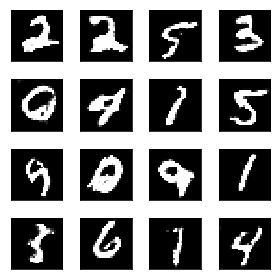

Epoch: 51/100 Discriminator Loss: 7.6115 Generator Loss: 8.4024
Epoch: 52/100 Discriminator Loss: 3.1540 Generator Loss: 4.8495
Epoch: 53/100 Discriminator Loss: 4.3332 Generator Loss: 6.5055
Epoch: 54/100 Discriminator Loss:12.3590 Generator Loss: 8.1080
Epoch: 55/100 Discriminator Loss: 4.6638 Generator Loss: 5.4209
Epoch: 56/100 Discriminator Loss: 3.3384 Generator Loss: 4.7753
Epoch: 57/100 Discriminator Loss:10.6583 Generator Loss:13.4086
Epoch: 58/100 Discriminator Loss: 5.9754 Generator Loss: 6.7819
Epoch: 59/100 Discriminator Loss:12.2714 Generator Loss:14.2139
Epoch: 60/100 Discriminator Loss: 1.6157 Generator Loss: 0.3940


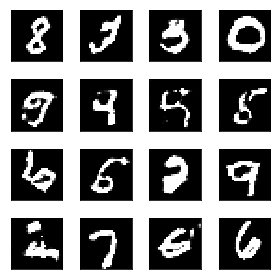

Epoch: 61/100 Discriminator Loss: 5.9068 Generator Loss: 8.3606
Epoch: 62/100 Discriminator Loss: 7.8007 Generator Loss: 9.3912
Epoch: 63/100 Discriminator Loss: 7.4724 Generator Loss: 7.2874
Epoch: 64/100 Discriminator Loss: 2.2464 Generator Loss: 3.8127
Epoch: 65/100 Discriminator Loss: 2.0069 Generator Loss: 3.6882
Epoch: 66/100 Discriminator Loss: 1.6710 Generator Loss: 1.6049
Epoch: 67/100 Discriminator Loss: 2.8142 Generator Loss: 4.4809
Epoch: 68/100 Discriminator Loss: 9.9063 Generator Loss: 8.6886
Epoch: 69/100 Discriminator Loss: 4.2432 Generator Loss: 3.1201
Epoch: 70/100 Discriminator Loss: 7.0648 Generator Loss: 6.6425


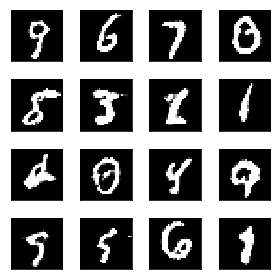

Epoch: 71/100 Discriminator Loss: 7.7313 Generator Loss: 7.1514
Epoch: 72/100 Discriminator Loss: 3.2209 Generator Loss: 5.3234
Epoch: 73/100 Discriminator Loss: 8.6805 Generator Loss:11.1244
Epoch: 74/100 Discriminator Loss: 4.2998 Generator Loss: 5.7357
Epoch: 75/100 Discriminator Loss: 3.6497 Generator Loss: 5.1979
Epoch: 76/100 Discriminator Loss: 2.8627 Generator Loss: 4.1946
Epoch: 77/100 Discriminator Loss: 9.0183 Generator Loss:10.1132
Epoch: 78/100 Discriminator Loss: 5.2753 Generator Loss: 6.0979
Epoch: 79/100 Discriminator Loss: 4.9583 Generator Loss: 5.2013
Epoch: 80/100 Discriminator Loss: 4.0454 Generator Loss: 2.5207


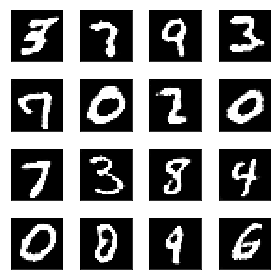

Epoch: 81/100 Discriminator Loss:10.2745 Generator Loss:10.8373
Epoch: 82/100 Discriminator Loss: 5.8246 Generator Loss: 8.3493
Epoch: 83/100 Discriminator Loss: 2.8714 Generator Loss: 3.9538
Epoch: 84/100 Discriminator Loss: 7.0895 Generator Loss: 8.0075
Epoch: 85/100 Discriminator Loss: 2.2065 Generator Loss: 4.0670
Epoch: 86/100 Discriminator Loss: 3.7588 Generator Loss: 4.4517
Epoch: 87/100 Discriminator Loss: 7.5616 Generator Loss: 6.6820
Epoch: 88/100 Discriminator Loss: 4.6492 Generator Loss: 4.5450
Epoch: 89/100 Discriminator Loss: 2.7562 Generator Loss: 4.2539
Epoch: 90/100 Discriminator Loss: 2.2547 Generator Loss: 2.9126


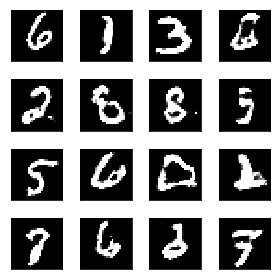

Epoch: 91/100 Discriminator Loss: 4.5685 Generator Loss: 4.7163
Epoch: 92/100 Discriminator Loss: 2.0306 Generator Loss: 3.6752
Epoch: 93/100 Discriminator Loss: 3.8741 Generator Loss: 6.4846
Epoch: 94/100 Discriminator Loss: 5.8666 Generator Loss: 4.8773
Epoch: 95/100 Discriminator Loss: 6.3757 Generator Loss: 8.1464
Epoch: 96/100 Discriminator Loss: 5.6843 Generator Loss: 4.7406
Epoch: 97/100 Discriminator Loss: 2.8612 Generator Loss: 3.5827
Epoch: 98/100 Discriminator Loss: 3.1296 Generator Loss: 4.4548
Epoch: 99/100 Discriminator Loss: 7.3210 Generator Loss: 8.5333
Epoch:100/100 Discriminator Loss: 2.2660 Generator Loss: 3.9263


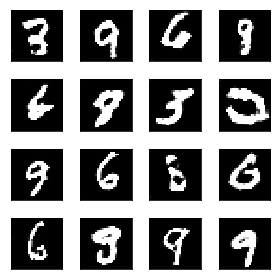

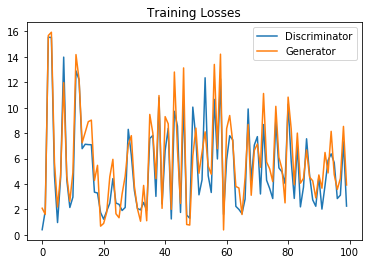

In [16]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);

I used leaky_relu=0.2 for the above experiment.  The losses oscillates more.  The generated images look as good.

## References

<a id="ref1"></a>
### [1] MNIST dataset
 
Yann LeCun
 
http://yann.lecun.com/exdb/mnist/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf